In [1]:
import os
import numpy as np
import librosa
import time
 
#%%
direc = "/content/drive/MyDrive/"
y_fb = np.load(direc+"freefield1010-labels.npy").astype(int)
X_fb = np.load(direc+"freefield1010-spectrograms.npy")[..., np.newaxis]
y_wb = np.load(direc+"warblrb10k-labels.npy").astype(int)
X_wb = np.load(direc+"warblrb10k-spectrograms.npy")[..., np.newaxis]

In [4]:
#%%
from sklearn.model_selection import train_test_split

trainX_wb, validX_wb, trainY_wb, validY_wb = train_test_split(X_wb, 
                                                            y_wb, 
                                                            test_size=0.3,
                                                            stratify=y_wb)



trainX_fb, validX_fb, trainY_fb, validY_fb = train_test_split(X_fb, 
                                                            y_fb, 
                                                            test_size=0.3,
                                                            stratify=y_fb)

validX_wb, testX_wb, validY_wb, testY_wb = train_test_split(validX_wb, 
                                                            validY_wb, 
                                                            test_size=0.33,
                                                            stratify=validY_wb)



validX_fb, testX_fb, validY_fb, testY_fb = train_test_split(validX_fb, 
                                                            validY_fb, 
                                                            test_size=0.33,
                                                            stratify=validY_fb)



In [19]:
validX = np.concatenate((validX_wb, validX_fb),)
validY = np.concatenate((validY_wb, validY_fb))

trainX = np.concatenate((trainX_wb, trainX_fb))
trainY = np.concatenate((trainY_wb, trainY_fb))

testX = np.concatenate((testX_wb, testX_fb))
testY = np.concatenate((testY_wb, testY_fb))

(array([764.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 790.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

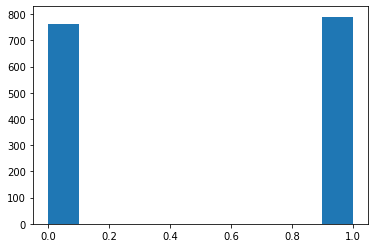

In [18]:
import matplotlib.pyplot as plt
plt.hist(testY)

In [59]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

fb_folds = skf.get_n_splits(X_fb, y_fb)
wb_folds = skf.get_n_splits(X_wb, y_wb)

In [22]:
#%%
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
 
filters = 64
dropout_rate = 0.3
model = Sequential()
 
model.add(Conv2D(filters, kernel_size=5, activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((1, 5)))
model.add(Dropout(dropout_rate))
 
model.add(Conv2D(filters, kernel_size=5, activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((1, 2)))
model.add(Dropout(dropout_rate))
 
model.add(Conv2D(filters, kernel_size=5, activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((1, 2)))
model.add(Dropout(dropout_rate))
 
model.add(Conv2D(filters, kernel_size=5, activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((1, 2)))
model.add(Dropout(dropout_rate))
 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(32, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

In [30]:
epochs = 200
batch_size = 64
learning_rate = 0.00001
print(f"Running {epochs} epochs with batch size of {batch_size} and learning rate of {learning_rate}.")
opt = tf.optimizers.Adam(lr=learning_rate)
 
# Keskeyttää fitin, jos validation accuracy ei parane 10 epochiin.
callback = EarlyStopping(monitor='val_auc', patience=10, 
                         restore_best_weights=True, mode="max")
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['AUC', 'accuracy'])

Running 200 epochs with batch size of 64 and learning rate of 1e-05.


In [32]:
#%% Without data augmentation
history = model.fit(trainX, trainY, 
                    epochs=epochs, 
                    validation_data=(validX, validY), 
                    batch_size=batch_size, 
                    callbacks=[callback],
                    verbose=2)
 
print("Finished")

Epoch 1/200
172/172 - 38s - loss: 0.2442 - auc: 0.9632 - accuracy: 0.8956 - val_loss: 0.8719 - val_auc: 0.8806 - val_accuracy: 0.8040
Epoch 2/200
172/172 - 37s - loss: 0.2380 - auc: 0.9647 - accuracy: 0.9002 - val_loss: 0.9964 - val_auc: 0.8669 - val_accuracy: 0.7942
Epoch 3/200
172/172 - 37s - loss: 0.2347 - auc: 0.9657 - accuracy: 0.9004 - val_loss: 0.7769 - val_auc: 0.9000 - val_accuracy: 0.8176
Epoch 4/200
172/172 - 37s - loss: 0.2280 - auc: 0.9676 - accuracy: 0.9046 - val_loss: 0.9073 - val_auc: 0.8769 - val_accuracy: 0.8049
Epoch 5/200
172/172 - 37s - loss: 0.2273 - auc: 0.9678 - accuracy: 0.9049 - val_loss: 0.6241 - val_auc: 0.9119 - val_accuracy: 0.8382
Epoch 6/200
172/172 - 37s - loss: 0.2206 - auc: 0.9698 - accuracy: 0.9085 - val_loss: 1.1494 - val_auc: 0.8563 - val_accuracy: 0.7821
Epoch 7/200
172/172 - 37s - loss: 0.2185 - auc: 0.9705 - accuracy: 0.9089 - val_loss: 0.8440 - val_auc: 0.8855 - val_accuracy: 0.8069
Epoch 8/200
172/172 - 37s - loss: 0.2167 - auc: 0.9709 - accur

Accuracy using model.predict: 0.8263


(array([490.,  62.,  30.,  28.,  52.,  41.,  34.,  38.,  44., 735.]),
 array([3.53211902e-07, 1.00000314e-01, 2.00000286e-01, 3.00000250e-01,
        4.00000215e-01, 5.00000179e-01, 6.00000143e-01, 7.00000107e-01,
        8.00000072e-01, 9.00000036e-01, 1.00000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

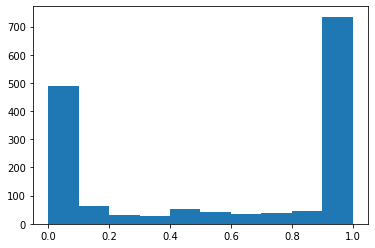

In [33]:
predY = np.round(np.squeeze(model.predict(testX, verbose=0)), decimals=0)
acc = np.sum(predY == testY) / testY.shape[0]
print(f"Accuracy using model.predict: {acc:.4f}")
import matplotlib.pyplot as plt
plt.hist(np.squeeze(model.predict(testX, verbose=0)))

In [26]:
model.save('model_good.h5')

In [54]:
model.save('warbird.h5')

In [55]:
fb_model = tf.keras.models.load_model('freebird.h5')
wb_model = tf.keras.models.load_model('warbird.h5')

In [27]:
submissionX = np.load(direc+"test-spectrograms.npy")[..., np.newaxis]
submissionX.shape

(4512, 862, 40, 1)

In [34]:
results = np.squeeze(model.predict(submissionX))
results.shape

(4512,)

In [56]:
results_wb = np.squeeze(wb_model.predict(submissionX))
results_fb = np.squeeze(fb_model.predict(submissionX))
results = np.average((results_wb, results_fb), axis=0)
results.shape

(4512,)

(array([ 40., 112., 437., 794., 499., 387., 500., 524., 412., 807.]),
 array([0.02851933, 0.1256674 , 0.22281547, 0.31996354, 0.4171116 ,
        0.51425964, 0.61140776, 0.7085558 , 0.8057039 , 0.90285194,
        1.        ], dtype=float32),
 <a list of 10 Patch objects>)

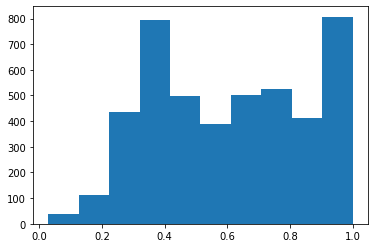

In [35]:
import matplotlib.pyplot as plt
plt.hist(results)

(array([116., 654., 809., 363., 980., 620., 164., 109.,  79., 618.]),
 array([0.01777291, 0.11599562, 0.21421833, 0.31244105, 0.41066375,
        0.50888646, 0.6071092 , 0.70533186, 0.8035546 , 0.90177727,
        1.        ], dtype=float32),
 <a list of 10 Patch objects>)

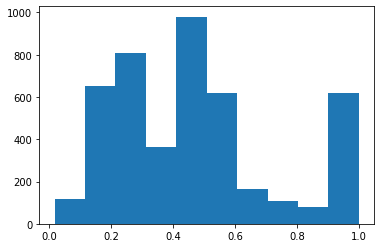

In [29]:
import matplotlib.pyplot as plt
plt.hist(results)

In [39]:
test_order = np.load("/content/drive/MyDrive/test_order.npy")
test_order.shape
test_list = []
for name in test_order:
  test_list.append(name.split(".")[0])
print(test_list)

['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '101', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '102', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '103', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '104', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '105', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '1059', '106', '1060', '1061', '1062', '1063', '1064', '1065', '1066', '1067', '1068', '1069', '107', '1070', '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079', '108', '1080', '1081', '1082', '1083', '1084', '1085', '1086', '1087', '1088', '1089', '109', '1090', '1091', '1092', '1093', '1094', '1095', '1096', '1097', '1098', '1099', '11', '110', '1100', '1101', '1102', '1103', '1104', '1105', '1106', '1107', '1108', '1109', '111', '1110', '1111

In [40]:
#%% kilpailutiedoston muodostaminen
with open("sample_submission2.csv", "w") as fp: 
    fp.write("ID,Predicted\n") 
    for idx in range(4512): 
        fp.write(f"{int(test_list[idx])},{results[idx]}\n") 
